<a href="https://colab.research.google.com/github/viicctor91/me.github.io/blob/main/Projeto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJETO FINAL

## Montando Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importando Pacotes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import gc
import os
import logging
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.cluster import KMeans
#from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
#from pandas_profiling import ProfileReport
%matplotlib inline

pd.set_option('display.max_columns', None)

In [ ]:
# pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

In [4]:
#lendo arquivos
df_sales = pd.read_csv("/content/drive/MyDrive/ARQUIVOS TFM/item_sales.csv")

In [5]:
df_prices = pd.read_csv("/content/drive/MyDrive/ARQUIVOS TFM/item_prices.csv")

In [6]:
df_calendar = pd.read_csv("/content/drive/MyDrive/ARQUIVOS TFM/daily_calendar_with_events.csv")

# Lendo arquivo final

In [ ]:
df_final_encoded = pd.read_csv("/content/drive/MyDrive/ARQUIVOS TFM/df_final_encoded.csv")

In [ ]:
df_final= pd.read_csv("/content/drive/MyDrive/ARQUIVOS TFM/df_final.csv")

### Dicionário de dados

File 1 – daily_calendar_with_events.csv

| Name | Description |
| --- | --- |
| date | date in y-m-d format |
| weekday |	day of the week |
| weekday_int |	numeric day of the week (Saturday day 1, Friday day 7) |
| d	| day identifier |
| event | if the date includes an event, the name of this event (only a few are included) |

File 2 – item_prices.csv

| Name | Description |
| --- | --- |
| item | product id |
| category | product category |
| store_code | alphanumeric code of the store |
| yearweek | date period for the price (year-week format) |
| sell_price |	price for the product “item” for the period in “yearweek”. * |

* Prices are provided per week (average across 7 days). If not available, there were no sales for the product during that week ludes an event, the name of this event (only a few are included).

File 3 – item_sales.csv

| Name | Description |
| --- | --- |
| id | sales series id (combination of item + store_code) |
| item | product id |
| category | product category |
| department | department id (different identifier for different stores) |
| store | store name |
| store_code | store id |
| region | region |
| d_1,d_2,d_... | number of units sold per day |

------

# Item Prices

## Pré-processamento e exploração de dados

In [7]:
#Monstra Colonas do datafrane item_prices
cols_df_price = pd.DataFrame(df_prices.columns, columns=['Column Names'])

display(cols_df_price)

,Column Names
0,item
1,category
2,store_code
3,yearweek
4,sell_price


In [9]:
# Primeiras cinco linhas do df
df_prices.head()

,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328.0,12.7414
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329.0,12.7414
2,ACCESORIES_1_001,ACCESORIES,NYC_1,201330.0,10.9858
3,ACCESORIES_1_001,ACCESORIES,NYC_1,201331.0,10.9858
4,ACCESORIES_1_001,ACCESORIES,NYC_1,201332.0,10.9858


In [10]:
# Cinco ultimas linhas
df_prices.tail()

,item,category,store_code,yearweek,sell_price
6965701,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2
6965702,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2
6965703,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2
6965704,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2
6965705,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2


In [11]:
# Dimensão do df
df_prices.shape

(6965706, 5)

In [12]:
df_prices.dtypes

item           object
category       object
store_code     object
yearweek      float64
sell_price    float64
dtype: object

In [13]:
df_prices.describe()

,yearweek,sell_price
count,6.721786e+06,6.965706e+06
mean,2.013824e+05,5.518273e+00
std,1.450189e+02,4.387861e+00
min,2.011050e+05,1.200000e-02
25%,2.012480e+05,2.620100e+00
50%,2.014100e+05,4.200000e+00
75%,2.015150e+05,7.176000e+00
max,2.016170e+05,1.341500e+02


In [14]:
df_prices.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965706 entries, 0 to 6965705
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   item        object 
 1   category    object 
 2   store_code  object 
 3   yearweek    float64
 4   sell_price  float64
dtypes: float64(2), object(3)
memory usage: 265.7+ MB


In [15]:
#verificando valores em falta
soma_missings_por_coluna = df_prices.isnull().sum()
soma_missings_por_coluna

item               0
category           0
store_code         0
yearweek      243920
sell_price         0
dtype: int64

In [17]:
#resultados em percentagem
tamanho_df_prices = len(df_prices)
round(soma_missings_por_coluna['yearweek']/tamanho_df_prices*100,2)

3.5

In [21]:
# Contar as ocorrências dos diferentes valores na coluna 'yearweek'
value_counts = df_prices['yearweek'].value_counts()

# Verificar a quantidade de ocorrências do valor 'nan' na coluna 'yearweek'
nan_count = value_counts.get('NaN', 0)

print(f"A quantidade de valores 'nan' na coluna 'yearweek' é {nan_count}.")

A quantidade de valores 'nan' na coluna 'yearweek' é 0.


### Tratamento da coluna Yearweek

In [ ]:
# Convertendo a coluna 'yearweek' para o tipo string
df_prices['yearweek'] = df_prices['yearweek'].astype(str)

# Remover linhas com valores vazios na coluna 'yearweek'
df_prices.dropna(subset=['yearweek'], inplace=True)

# Elimine as linhas que contenham a string 'nan' na coluna 'yearweek'
df_prices = df_prices[~df_prices['yearweek'].isin(['nan'])]

# Mantenha apenas os 6 primeiros caracteres na coluna 'yearweek'
df_prices['yearweek'] = df_prices['yearweek'].str.slice(0, 6)

# Ordenando o dataframe pela coluna yearweek
df_prices.sort_values('yearweek', inplace=True)

# Exiba o DataFrame reordenado
print(df_prices)

                        item       category store_code yearweek  sell_price
5539160    SUPERMARKET_3_702    SUPERMARKET      PHI_1   201105      3.9360
6613947  HOME_&_GARDEN_2_445  HOME_&_GARDEN      PHI_3   201105      8.1000
261069   HOME_&_GARDEN_2_041  HOME_&_GARDEN      NYC_1   201105      6.5875
1516539  HOME_&_GARDEN_1_117  HOME_&_GARDEN      NYC_3   201105     11.2125
563249     SUPERMARKET_3_188    SUPERMARKET      NYC_1   201105      2.3760
...                      ...            ...        ...      ...         ...
2386874  HOME_&_GARDEN_2_338  HOME_&_GARDEN      NYC_4   201617      6.1500
2387152  HOME_&_GARDEN_2_339  HOME_&_GARDEN      NYC_4   201617      8.0750
6156810    SUPERMARKET_3_382    SUPERMARKET      PHI_2   201617      2.1360
2386079  HOME_&_GARDEN_2_334  HOME_&_GARDEN      NYC_4   201617      3.7250
6965697    SUPERMARKET_3_827    SUPERMARKET      PHI_3   201617      1.2000

[6721786 rows x 5 columns]


In [ ]:
# Verificando se ainda existe valores nulos no df
df_prices.isnull().sum()/len(df_prices)*100

In [ ]:
#verificando valores duplicador no df
df_prices.duplicated().sum()/len(df_prices)*100

### Função para observar cada coluna do df

In [ ]:
def Price_func(data, column, count=True):
    unique_values = data[column].unique()
    null_count = data[column].isnull().sum()
    value_counts = data[column].value_counts()

    print(f'Quantidade de valores únicos: {len(unique_values)}')
    print(f'\nQuais são os valores únicos: {unique_values}')
    print(f'\nQuantidade de valores nulos: {null_count}')
    print(f'\nQuantidade por opção: \n{value_counts}')

#### Coluna Item

In [ ]:
Price_func(df_prices, 'item')

Quantidade de valores únicos: 3049

Quais são os valores únicos: ['SUPERMARKET_3_702' 'HOME_&_GARDEN_2_445' 'HOME_&_GARDEN_2_041' ...
 'SUPERMARKET_3_647' 'SUPERMARKET_3_038' 'HOME_&_GARDEN_1_159']

Quantidade de valores nulos: 0

Quantidade por opção: 
SUPERMARKET_3_702      2790
HOME_&_GARDEN_1_234    2790
ACCESORIES_1_194       2790
SUPERMARKET_1_168      2790
SUPERMARKET_3_590      2790
                       ... 
HOME_&_GARDEN_1_308     572
HOME_&_GARDEN_1_159     553
HOME_&_GARDEN_1_242     530
SUPERMARKET_3_296       522
SUPERMARKET_2_379       463
Name: item, Length: 3049, dtype: int64


#### Coluna Category

In [ ]:
Price_func(df_prices, 'category')

#### Coluna Store_code

In [ ]:
Price_func(df_prices, 'store_code')

Quantidade de valores únicos: 10

Quais são os valores únicos: ['PHI_1' 'PHI_3' 'NYC_1' 'NYC_3' 'BOS_3' 'BOS_1' 'PHI_2' 'BOS_2' 'NYC_4'
 'NYC_2']

Quantidade de valores nulos: 0

Quantidade por opção: 
BOS_2    689568
BOS_1    688135
NYC_1    686681
PHI_3    684355
NYC_3    682193
BOS_3    679290
NYC_4    666983
PHI_2    666154
PHI_1    653817
NYC_2    624610
Name: store_code, dtype: int64


#### Coluna Yearweek

In [ ]:
Price_func(df_prices, 'yearweek')

#### Coluna Sell_price

In [ ]:
Price_func(df_prices, 'sell_price')

Quantidade de valores únicos: 1860

Quais são os valores únicos: [ 3.936   8.1     6.5875 ... 18.05   34.5268  8.5519]

Quantidade de valores nulos: 0

Quantidade por opção: 
2.3760     213714
3.5760     208588
3.0000     182471
1.2000     145538
4.7760     137539
            ...  
0.7500          1
65.7750         1
3.5910          1
0.4522          1
8.5519          1
Name: sell_price, Length: 1860, dtype: int64


In [ ]:
price_stats = df_prices.groupby("category")["sell_price"].agg(["mean", "median", "std"])
print(price_stats)

                   mean  median       std
category                                 
ACCESORIES     7.084900  5.2801  6.407456
HOME_&_GARDEN  6.831756  6.1750  4.215574
SUPERMARKET    3.897322  3.2160  2.555745


In [ ]:
df_prices.head()

,item,category,store_code,yearweek,sell_price
5539160,SUPERMARKET_3_702,SUPERMARKET,PHI_1,201105,3.9360
6613947,HOME_&_GARDEN_2_445,HOME_&_GARDEN,PHI_3,201105,8.1000
261069,HOME_&_GARDEN_2_041,HOME_&_GARDEN,NYC_1,201105,6.5875
1516539,HOME_&_GARDEN_1_117,HOME_&_GARDEN,NYC_3,201105,11.2125
563249,SUPERMARKET_3_188,SUPERMARKET,NYC_1,201105,2.3760


# Item Sales

## Pré-processamento e exploração de dados

In [ ]:
cols_df_sales = pd.DataFrame(df_sales.columns, columns=['Column Names'])

display(cols_df_sales)

,Column Names
0,id
1,item
2,category
3,department
4,store
...,...
1915,d_1909
1916,d_1910
1917,d_1911
1918,d_1912


In [ ]:
#primeiras 5 linhas do df_sales
df_sales.head()

In [ ]:
# Cinco ultimas linhas
df_sales.tail()

In [ ]:
df_sales.shape

In [ ]:
df_sales.dtypes

In [ ]:
df_sales.describe()

In [ ]:
#df_sales.info(verbose=True)

In [ ]:
#verificando valores em falta
soma_missings_por_coluna = df_sales.isnull().sum()
soma_missings_por_coluna

id            0
item          0
category      0
department    0
store         0
             ..
d_1909        0
d_1910        0
d_1911        0
d_1912        0
d_1913        0
Length: 1920, dtype: int64

### Separando o item Sales por dados Categoricos

In [ ]:
df_sales_cat = df_sales.iloc[:,0:7]
df_sales_cat

,id,item,category,department,store,store_code,region
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York
...,...,...,...,...,...,...,...
1319,HOME_&_GARDEN_2_224_NYC_1,HOME_&_GARDEN_2_224,HOME_&_GARDEN,HOME_&_GARDEN_2,Greenwich_Village,NYC_1,New York
1320,HOME_&_GARDEN_2_225_NYC_1,HOME_&_GARDEN_2_225,HOME_&_GARDEN,HOME_&_GARDEN_2,Greenwich_Village,NYC_1,New York
1321,HOME_&_GARDEN_2_226_NYC_1,HOME_&_GARDEN_2_226,HOME_&_GARDEN,HOME_&_GARDEN_2,Greenwich_Village,NYC_1,New York
1322,HOME_&_GARDEN_2_227_NYC_1,HOME_&_GARDEN_2_227,HOME_&_GARDEN,HOME_&_GARDEN_2,Greenwich_Village,NYC_1,New York


### Separando o item Sales por dados Numericos

In [ ]:
#df_units_pday = df_sales.iloc[:, 7:].T.reset_index().rename(columns={"index": "d"})
#df_units_pday

### Função para observar cada coluna do df

In [ ]:
def sales_func(data, column, count=True):
    unique_values = data[column].unique()
    null_count = data[column].isnull().sum()
    value_counts = data[column].value_counts()

    print(f'Quantidade de valores únicos: {len(unique_values)}')
    print(f'\nQuais são os valores únicos: {unique_values}')
    print(f'\nQuantidade de valores nulos: {null_count}')
    print(f'\nQuantidade por opção: \n{value_counts}')

#### Coluna id

In [24]:
sales_func(df_sales_cat, 'id')

NameError: ignored

#### Coluna item

In [ ]:
sales_func(df_sales_cat, 'item')

In [ ]:
sales_func(df_sales_cat, 'category')

In [ ]:
sales_func(df_sales_cat, 'department')

In [ ]:
sales_func(df_sales_cat, 'store')

In [ ]:
sales_func(df_sales_cat, 'store_code')

In [ ]:
sales_func(df_sales_cat, 'region')

In [ ]:
df_sales_cat.head(10)

In [ ]:
# Agrupar por 'region' e listar todas as lojas associadas a cada região
lojas_por_regiao = df_sales.groupby('region')['store'].unique()

print(lojas_por_regiao)



In [ ]:
df_group = df_sales.groupby("region")["store_code"].value_counts()
print(df_group)

In [ ]:
df_sales['department'].unique()

In [ ]:
df_sales['id'].unique()

# Daily Calendar with Events

In [ ]:
df_calendar = pd.read_csv("daily_calendar_with_events.csv")

In [ ]:
df_calendar.shape

In [ ]:
df_calendar.describe()

In [ ]:
cols_df_calendar = pd.DataFrame(df_calendar.columns, columns=['Column Names'])

display(cols_df_calendar)

In [ ]:
df_calendar.head()

In [ ]:
df_calendar.isnull().sum()

In [ ]:
sales_func( df_sales,

# Juntando as Tabelas


## Transformação de df_sales:

In [23]:
# 1. Defina o tamanho do chunk
chunk_size = 500

# 2. Divida as colunas d_ em chunks
d_cols = [f'd_{i}' for i in range(1, 1914)]
d_chunks = [d_cols[i:i + chunk_size] for i in range(0, len(d_cols), chunk_size)]

# 3. Realize a operação melt em cada chunk e salve no disco
melted_files = []
for i, d_chunk in enumerate(d_chunks):
    melted_df = df_sales.melt(id_vars=['id', 'item', 'category', 'department', 'store', 'store_code', 'region'],
                              value_vars=d_chunk,
                              var_name='d',
                              value_name='sold_units')

    # Convertendo para tipos de dados menores
    melted_df['sold_units'] = melted_df['sold_units'].astype('int16')

    # Salvando o dataframe derretido como um arquivo CSV
    file_name = f"melted_chunk_{i}.csv"
    melted_df.to_csv(file_name, index=False)
    melted_files.append(file_name)

    # Liberando memória
    del melted_df
    gc.collect()

# 4. Lendo cada arquivo CSV e concatenando-os para criar o dataframe final
df_list = []

for file in melted_files:
    df = pd.read_csv(file)
    df_list.append(df)

# Concatenando todos os dataframes
df_sales_melted = pd.concat(df_list, ignore_index=True)

# Liberando memória
del df_list
gc.collect()

# Após terminar de usar os arquivos CSV, exclua-os para liberar espaço em disco
for file in melted_files:
    os.remove(file)

# Libere a memória das variáveis temporárias
del melted_files
gc.collect()

# Agora, df_sales_melted é o seu dataframe final após a operação de melt
df_sales_melted.head()



,id,item,category,department,store,store_code,region,d,sold_units
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0


In [22]:
df_sales_melted.shape

NameError: ignored

## Juntar com daily_calendar_with_events:

In [ ]:
# Função para reduzir o uso de memória
def reduce_memory(df):
    for col in df.columns:
        if pd.api.types.is_integer_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif pd.api.types.is_float_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif pd.api.types.is_object_dtype(df[col]):
            df[col] = df[col].astype('category')
    return df

# Verificar o tipo de dados da coluna 'd' em df_calendar e converter para string se necessário
if df_calendar['d'].dtype != 'object':
    df_calendar['d'] = df_calendar['d'].astype(str)

# Extrair a parte numérica e converter para int32
df_calendar['d'] = df_calendar['d'].str.extract('(\d+)').astype('int32')

# Reduzir o uso de memória do df_calendar
df_calendar = reduce_memory(df_calendar)

# Suponhamos que cada chunk terá 100,000 linhas
chunk_size = 100000
chunks = [x for x in range(0, df_sales_melted.shape[0], chunk_size)]

# Lista para guardar os nomes dos arquivos temporários
temp_files = []

# Loop para percorrer cada chunk e realizar a junção com df_calendar
for i, start in enumerate(chunks):
    # Pegar o pedaço do DataFrame
    subset = df_sales_melted.iloc[start:start+chunk_size].copy()

    # Converter a parte numérica da coluna 'd' para int32 para o subset
    subset['d'] = subset['d'].str.extract('(\d+)').astype('int32')

    # Junção com df_calendar
    merged_subset = pd.merge(subset, df_calendar, on='d', how='left')

    # Reduzir o uso de memória do df mesclado
    merged_subset = reduce_memory(merged_subset)

    # Nome do arquivo temporário
    temp_file_name = f"merged_chunk_{i}.csv"

    # Salvar o DataFrame mesclado como um arquivo CSV temporário
    merged_subset.to_csv(temp_file_name, index=False)

    # Adicionar o nome do arquivo à lista de arquivos temporários
    temp_files.append(temp_file_name)

    # Liberar memória
    del merged_subset, subset
    gc.collect()

# Lendo cada arquivo CSV mesclado e concatenando-os para criar o DataFrame final
df_list = []

for file in temp_files:
    df = pd.read_csv(file)
    df_list.append(reduce_memory(df))

# Concatenando todos os DataFrames
df_sales_calendar = pd.concat(df_list, ignore_index=True)

# Liberar memória
del df_list
gc.collect()

# Excluir arquivos temporários
for file in temp_files:
    os.remove(file)

# Agora, df_sales_calendar é o seu DataFrame final após a operação de junção
df_sales_calendar.head()

<ipython-input-10-e00cb8734ec7>:60: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-10-e00cb8734ec7>:60: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-10-e00cb8734ec7>:60: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-10-e00cb8734ec7>:60: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-10-e00cb8734ec7>:60: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-10-e00cb8734ec7>:60: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-10-e00cb8734e

,id,item,category,department,store,store_code,region,d,sold_units,date,weekday,weekday_int,event
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1,0,2011-01-29,Saturday,1,NaN
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1,0,2011-01-29,Saturday,1,NaN
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1,0,2011-01-29,Saturday,1,NaN
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1,0,2011-01-29,Saturday,1,NaN
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1,0,2011-01-29,Saturday,1,NaN


## Extrair o 'yearweek' a partir da coluna 'date':

In [ ]:
# Converter a coluna 'date' para datetime, se ainda não for
df_sales_calendar['date'] = pd.to_datetime(df_sales_calendar['date'])

# Extrair o 'yearweek' e converter para int32 para economizar memória
df_sales_calendar['yearweek'] = df_sales_calendar['date'].dt.strftime('%Y%U').astype('int32')

# Reduzir o uso de memória do df_sales_calendar após adicionar a coluna 'yearweek'
df_sales_calendar = reduce_memory(df_sales_calendar)

# Liberar memória
gc.collect()

# Salvar o DataFrame final, se necessário
# df_sales_calendar.to_csv('df_sales_calendar_final.csv', index=False)

# Excluir arquivos temporários, se existirem
temp_files = ['df_sales_calendar.csv']  # Adicione os nomes de todos os arquivos temporários aqui
for file in temp_files:
    if os.path.exists(file):
        os.remove(file)

## Juntar com item_prices:

In [ ]:
logging.basicConfig(level=logging.INFO)

def optimize_dataframe(df):
    """Optimize DataFrame types for memory usage."""
    categorical_cols = ['item', 'category', 'department', 'store', 'store_code', 'region', 'weekday', 'event']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')

    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')

    return df

def fill_missing_values(df, avg_sell_price_per_item):
    """Fill missing values in DataFrame."""
    if 'event' in df.columns:
        if pd.api.types.is_categorical_dtype(df['event']):
            df['event'] = df['event'].cat.add_categories(['Sem evento'])
        df['event'].fillna('Sem evento', inplace=True)

    if 'sell_price' in df.columns:
        df['sell_price'].fillna(df['item'].map(avg_sell_price_per_item.set_index('item')['sell_price']), inplace=True)
        df['sell_price'].fillna(0, inplace=True)  # Caso algum item ainda esteja faltando

    return df

def merge_in_chunks(df_main, df_secondary, avg_sell_price_per_item, on_columns, n_chunks=20, how='left'):
    """Perform merge operation in chunks for large DataFrames."""
    chunk_size = len(df_main) // n_chunks
    merged_dfs = []
    logging.info('Starting the merge process...')

    for i in range(n_chunks):
        logging.info(f'Processing chunk {i+1}/{n_chunks}')
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size if i != n_chunks - 1 else None

        chunk = df_main.iloc[start_idx:end_idx].copy()
        merged_chunk = pd.merge(chunk, df_secondary, on=on_columns, how=how)

        # Drop duplicate columns
        merged_chunk.drop([col for col in merged_chunk.columns if col.endswith('_y')], axis=1, inplace=True)

        merged_chunk = fill_missing_values(merged_chunk, avg_sell_price_per_item)
        merged_chunk = optimize_dataframe(merged_chunk)

        merged_dfs.append(merged_chunk)

    logging.info('Merge process completed.')
    return pd.concat(merged_dfs, ignore_index=True)

# Assuming df_sales_calendar and df_prices have been read into memory
# df_sales_calendar = pd.read_csv("sales_calendar.csv")
# df_prices = pd.read_csv("prices.csv")

# Calculate the mean sell_price for each item in df_prices
avg_sell_price_per_item = df_prices.groupby('item')['sell_price'].mean().reset_index()

# Optimize DataFrames already in memory
df_sales_calendar = optimize_dataframe(df_sales_calendar)
df_prices = optimize_dataframe(df_prices)

# Columns to merge on
on_columns = ['item', 'store_code', 'yearweek']

# Perform the merge operation in chunks
df_final = merge_in_chunks(df_sales_calendar, df_prices, avg_sell_price_per_item, on_columns, n_chunks=20)

# Delete temporary CSV files after the merge
melted_files = [f"melted_chunk_{i}.csv" for i in range(len(d_chunks))]
for file in melted_files:
    if os.path.exists(file):
        os.remove(file)

# df_final is now your final DataFrame after the merge operation
print(df_final.head())

# Free up memory
gc.collect()

                       id              item  category_x    department  \
0  ACCESORIES_1_001_NYC_1  ACCESORIES_1_001  ACCESORIES  ACCESORIES_1   
1  ACCESORIES_1_002_NYC_1  ACCESORIES_1_002  ACCESORIES  ACCESORIES_1   
2  ACCESORIES_1_003_NYC_1  ACCESORIES_1_003  ACCESORIES  ACCESORIES_1   
3  ACCESORIES_1_004_NYC_1  ACCESORIES_1_004  ACCESORIES  ACCESORIES_1   
4  ACCESORIES_1_005_NYC_1  ACCESORIES_1_005  ACCESORIES  ACCESORIES_1   

               store store_code    region  d  sold_units       date   weekday  \
0  Greenwich_Village      NYC_1  New York  1           0 2011-01-29  Saturday   
1  Greenwich_Village      NYC_1  New York  1           0 2011-01-29  Saturday   
2  Greenwich_Village      NYC_1  New York  1           0 2011-01-29  Saturday   
3  Greenwich_Village      NYC_1  New York  1           0 2011-01-29  Saturday   
4  Greenwich_Village      NYC_1  New York  1           0 2011-01-29  Saturday   

   weekday_int       event  yearweek  sell_price  
0            1  Sem eve

7340

# DataFrame Final

In [ ]:
df_final.head()

,id,item,category_x,department,store,store_code,region,d,sold_units,date,weekday,weekday_int,event,yearweek,sell_price
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1,0,2011-01-29,Saturday,1,Sem evento,201104,11.036664
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1,0,2011-01-29,Saturday,1,Sem evento,201104,5.275608
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1,0,2011-01-29,Saturday,1,Sem evento,201104,3.944025
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1,0,2011-01-29,Saturday,1,Sem evento,201104,5.981872
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,1,0,2011-01-29,Saturday,1,Sem evento,201104,3.831799


In [ ]:
df_final.shape

(58327370, 15)

In [ ]:
df_final.category_x.value_counts()

SUPERMARKET      27489810
HOME_&_GARDEN    20029110
ACCESORIES       10808450
Name: category_x, dtype: int64

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 15 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           category      
 1   item         category      
 2   category_x   category      
 3   department   category      
 4   store        category      
 5   store_code   category      
 6   region       category      
 7   d            int16         
 8   sold_units   int16         
 9   date         datetime64[ns]
 10  weekday      category      
 11  weekday_int  int8          
 12  event        category      
 13  yearweek     int32         
 14  sell_price   float32       
dtypes: category(9), datetime64[ns](1), float32(1), int16(2), int32(1), int8(1)
memory usage: 1.7 GB


# Codificação One Hot das colunas Categoricas

In [ ]:
# Supondo que df_final seja o seu DataFrame
# Fazendo uma cópia do DataFrame original para manter os dados originais intactos
df_final_encoded = df_final.copy()

# Selecionando as colunas categóricas que serão codificadas
cat_columns = ['event', 'region', 'store', 'category_x']

# Realizando a codificação one-hot e armazenando em um novo DataFrame
one_hot_encoded = pd.get_dummies(df_final[cat_columns], drop_first=False)

# Descartando as colunas categóricas originais do DataFrame copiado
df_final_encoded.drop(cat_columns, axis=1, inplace=True)

# Concatenando o DataFrame original copiado com as novas colunas codificadas
df_final_encoded = pd.concat([df_final_encoded, one_hot_encoded], axis=1)

# Mostrando as primeiras linhas do DataFrame codificado
print(df_final_encoded.head())


                       id              item    department store_code  d  \
0  ACCESORIES_1_001_NYC_1  ACCESORIES_1_001  ACCESORIES_1      NYC_1  1   
1  ACCESORIES_1_002_NYC_1  ACCESORIES_1_002  ACCESORIES_1      NYC_1  1   
2  ACCESORIES_1_003_NYC_1  ACCESORIES_1_003  ACCESORIES_1      NYC_1  1   
3  ACCESORIES_1_004_NYC_1  ACCESORIES_1_004  ACCESORIES_1      NYC_1  1   
4  ACCESORIES_1_005_NYC_1  ACCESORIES_1_005  ACCESORIES_1      NYC_1  1   

   sold_units        date   weekday  weekday_int  yearweek  sell_price  \
0           0  2011-01-29  Saturday            1    201104   11.036664   
1           0  2011-01-29  Saturday            1    201104    5.275608   
2           0  2011-01-29  Saturday            1    201104    3.944025   
3           0  2011-01-29  Saturday            1    201104    5.981872   
4           0  2011-01-29  Saturday            1    201104    3.831799   

   event_Easter  event_NewYear  event_Ramadan starts  event_Sem evento  \
0             0              0

In [ ]:
df_final_encoded.head()

,id,item,department,store_code,d,sold_units,date,weekday,weekday_int,yearweek,sell_price,event_Easter,event_NewYear,event_Ramadan starts,event_Sem evento,event_SuperBowl,event_Thanksgiving,region_Boston,region_New York,region_Philadelphia,store_Back_Bay,store_Brooklyn,store_Greenwich_Village,store_Harlem,store_Midtown_Village,store_Queen_Village,store_Roxbury,store_South_End,store_Tribeca,store_Yorktown,category_x_ACCESORIES,category_x_HOME_&_GARDEN,category_x_SUPERMARKET
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES_1,NYC_1,1,0,2011-01-29,Saturday,1,201104,11.036664,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES_1,NYC_1,1,0,2011-01-29,Saturday,1,201104,5.275608,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES_1,NYC_1,1,0,2011-01-29,Saturday,1,201104,3.944025,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES_1,NYC_1,1,0,2011-01-29,Saturday,1,201104,5.981872,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES_1,NYC_1,1,0,2011-01-29,Saturday,1,201104,3.831799,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_final_encoded.shape

(58327370, 33)

In [ ]:
# Monta o Google Drive
drive.mount('/content/drive')
# Salva o DataFrame como um arquivo CSV no Google Drive
df_final_encoded.to_csv('/content/drive/My Drive/df_final_encoded.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Verificar quais  produtos que não são mais tão populares

In [ ]:
# Função para identificar produtos menos populares
def identify_less_popular_products(df):
    # Transformando a coluna 'date' em datetime
    df['date'] = pd.to_datetime(df['date'])

    # Definindo o período de tempo para os últimos três meses e três meses antes disso
    end_date = df['date'].max()
    start_date_last_3_months = end_date - pd.DateOffset(months=3)
    start_date_prev_3_months = start_date_last_3_months - pd.DateOffset(months=3)

    # Filtrando o DataFrame para os produtos vendidos nos últimos 6 meses
    last_6_months_sales = df[df['date'] > start_date_prev_3_months]

    # Calculando a média de vendas por produto nos últimos três meses e nos três meses anteriores
    avg_sales_last_3_months = last_6_months_sales[last_6_months_sales['date'] > start_date_last_3_months].groupby('item')['sold_units'].mean()
    avg_sales_prev_3_months = last_6_months_sales[last_6_months_sales['date'] <= start_date_last_3_months].groupby('item')['sold_units'].mean()

    # Juntando as duas séries e calculando a diferença percentual
    sales_comparison = pd.concat([avg_sales_prev_3_months, avg_sales_last_3_months], axis=1, keys=['Prev_3_months', 'Last_3_months'])
    sales_comparison['Sales_decline_percent (%)'] = ((sales_comparison['Prev_3_months'] - sales_comparison['Last_3_months']) / sales_comparison['Prev_3_months']) * 100

    # Arredondando as colunas numéricas
    sales_comparison['Sales_decline_percent (%)'] = sales_comparison['Sales_decline_percent (%)'].round(2)
    sales_comparison[['Prev_3_months', 'Last_3_months']] = sales_comparison[['Prev_3_months', 'Last_3_months']].round(4)

    # Filtrando e ordenando produtos menos populares
    less_popular_products = sales_comparison[sales_comparison['Sales_decline_percent (%)'] > 20]
    less_popular_products_sorted = less_popular_products.sort_values(by='Sales_decline_percent (%)', ascending=False)

    # Alterando o tipo de dados para float32
    less_popular_products_sorted = less_popular_products_sorted.astype('float32')

    return less_popular_products_sorted

less_popular_products_sorted = identify_less_popular_products(df_final)

print(less_popular_products_sorted)

# Salvando o DataFrame arredondado como um arquivo CSV
less_popular_products_sorted.to_csv('less_popular_products_sorted.csv', float_format='%.3f')



                     Prev_3_months  Last_3_months  Sales_decline_percent (%)
item                                                                        
SUPERMARKET_3_441           0.1141         0.0000                 100.000000
SUPERMARKET_3_444           0.2087         0.0000                 100.000000
HOME_&_GARDEN_2_108         0.2217         0.0011                  99.500000
ACCESORIES_1_236            0.6348         0.0088                  98.620003
HOME_&_GARDEN_2_202         0.0793         0.0011                  98.620003
...                            ...            ...                        ...
ACCESORIES_1_002            0.3315         0.2637                  20.450001
HOME_&_GARDEN_1_194         1.3772         1.0967                  20.370001
SUPERMARKET_3_505           3.0174         2.4077                  20.209999
HOME_&_GARDEN_2_087         0.0674         0.0538                  20.100000
HOME_&_GARDEN_1_005         1.5250         1.2198                  20.010000

In [ ]:
import pandas as pd

# Função para identificar produtos menos populares
def identify_less_popular_products(df):
    df['date'] = pd.to_datetime(df['date'])
    end_date = df['date'].max()
    start_date_last_3_months = end_date - pd.DateOffset(months=3)
    start_date_prev_3_months = start_date_last_3_months - pd.DateOffset(months=3)

    last_6_months_sales = df[df['date'] > start_date_prev_3_months]
    avg_sales_last_3_months = last_6_months_sales[last_6_months_sales['date'] > start_date_last_3_months].groupby('item')['sold_units'].mean()
    avg_sales_prev_3_months = last_6_months_sales[last_6_months_sales['date'] <= start_date_last_3_months].groupby('item')['sold_units'].mean()

    sales_comparison = pd.concat([avg_sales_prev_3_months, avg_sales_last_3_months], axis=1, keys=['Prev_3_months', 'Last_3_months'])
    sales_comparison['Sales_decline_percent (%)'] = ((sales_comparison['Prev_3_months'] - sales_comparison['Last_3_months']) / sales_comparison['Prev_3_months']) * 100
    sales_comparison['Sales_decline_percent (%)'] = sales_comparison['Sales_decline_percent (%)'].round(2)
    sales_comparison[['Prev_3_months', 'Last_3_months']] = sales_comparison[['Prev_3_months', 'Last_3_months']].round(4)

    less_popular_products = sales_comparison[sales_comparison['Sales_decline_percent (%)'] > 20]
    less_popular_products_sorted = less_popular_products.sort_values(by='Sales_decline_percent (%)', ascending=False)
    less_popular_products_sorted = less_popular_products_sorted.astype('float32')

    return less_popular_products_sorted

# Identificar produtos menos populares
less_popular_products_sorted = identify_less_popular_products(df_final)

# Adicionando a coluna da categoria
item_to_category = df_final[['item', 'category_x']].drop_duplicates()
less_popular_products_sorted = less_popular_products_sorted.reset_index()
less_popular_products_sorted = less_popular_products_sorted.merge(item_to_category, on='item', how='left')

# Agrupar por categoria e encontrar os 10 itens menos vendidos em cada uma
grouped = less_popular_products_sorted.groupby('category_x')
top_10_declining_per_category = grouped.apply(lambda x: x.nlargest(10, 'Sales_decline_percent (%)')).reset_index(drop=True)

# Configurando a coluna 'category_x' como índice
top_10_declining_per_category.set_index('category_x', inplace=True)

top_10_declining_per_category


,item,Prev_3_months,Last_3_months,Sales_decline_percent (%)
category_x,,,,
ACCESORIES,ACCESORIES_1_236,0.6348,0.0088,98.620003
ACCESORIES,ACCESORIES_2_110,0.0924,0.0132,85.730003
ACCESORIES,ACCESORIES_2_122,0.5815,0.1923,66.930000
ACCESORIES,ACCESORIES_2_113,0.2870,0.0989,65.529999
ACCESORIES,ACCESORIES_2_083,0.2913,0.1022,64.919998
ACCESORIES,ACCESORIES_2_002,0.3859,0.1418,63.259998
ACCESORIES,ACCESORIES_2_121,1.0478,0.4538,56.689999
ACCESORIES,ACCESORIES_2_142,1.8120,0.8055,55.549999
ACCESORIES,ACCESORIES_2_148,0.5696,0.2538,55.430000


In [ ]:
# Salva o DataFrame como um arquivo CSV no Google Drive
less_popular_products_sorted.to_csv('/content/gdrive/My Drive/less_popular_products_sorted.csv', index=False)

## Verificar os produtos mais populares entre as cidades

In [ ]:
N = 5

# Agrupando por loja, produto e somando as vendas
store_product_sales = df_final.groupby(['store', 'item'])['sold_units'].sum().reset_index()

# Lista para armazenar os produtos mais populares por loja
top_products_list = []

for store in store_product_sales['store'].unique():
    store_sales = store_product_sales[store_product_sales['store'] == store]

    # Ordenando os produtos por vendas e pegando os top N produtos mais populares
    top_products = store_sales.sort_values(by='sold_units', ascending=False).head(N)

    top_products_list.append(top_products)

# Concatenando os resultados para criar o DataFrame final
top_products_per_store = pd.concat(top_products_list, axis=0)

print(top_products_per_store[['store', 'item', 'sold_units']])




                   store               item  sold_units
2810            Back_Bay  SUPERMARKET_3_586      150122
2314            Back_Bay  SUPERMARKET_3_090      114854
2476            Back_Bay  SUPERMARKET_3_252       86632
2779            Back_Bay  SUPERMARKET_3_555       77673
2601            Back_Bay  SUPERMARKET_3_377       73797
5363            Brooklyn  SUPERMARKET_3_090       52264
5859            Brooklyn  SUPERMARKET_3_586       32557
5860            Brooklyn  SUPERMARKET_3_587       24333
5525            Brooklyn  SUPERMARKET_3_252       23417
6078            Brooklyn  SUPERMARKET_3_808       21282
8412   Greenwich_Village  SUPERMARKET_3_090      127203
8908   Greenwich_Village  SUPERMARKET_3_586       87691
8574   Greenwich_Village  SUPERMARKET_3_252       74971
8442   Greenwich_Village  SUPERMARKET_3_120       61899
9035   Greenwich_Village  SUPERMARKET_3_714       54080
11957             Harlem  SUPERMARKET_3_586       63416
11623             Harlem  SUPERMARKET_3_252     

## Verifivar os produtos mais populares entre as lojas, levando em conta que os preços desses produtos podem ser diferentes de uma loja para outra.

In [ ]:
# Configuração para exibir números float com duas casas decimais
pd.options.display.float_format = "{:.2f}".format

# Número de produtos mais populares que você quer ver
N = 20  # você pode definir N como qualquer número que você quiser

# Calculando o faturamento (agora nomeado como 'receita')
df_final['receita'] = df_final['sold_units'] * df_final['sell_price']

# Agrupando por loja e produto e somando as vendas e receita
store_product_sales_revenue = df_final.groupby(['store', 'item']).agg({'sold_units': 'sum', 'receita': 'sum'}).reset_index()

# Identificar os produtos mais populares globalmente (em todas as lojas)
global_top_products = store_product_sales_revenue.groupby('item').agg({'sold_units': 'sum', 'receita': 'sum'}).sort_values(by='sold_units', ascending=False).head(N)

# Arredondando os valores para duas casas decimais
global_top_products = global_top_products.round(2)

# Formatando a coluna 'receita' para exibir valores em dólares de forma legível
global_top_products['receita'] = global_top_products['receita'].apply(lambda x: f"${x:,.2f}")

# Exibindo o DataFrame dos produtos mais populares
print("Produtos mais populares globalmente:")
print(global_top_products)

# Se quiser exportar para CSV
# global_top_products.to_csv('global_top_products.csv', index=False)



Produtos mais populares globalmente:
                   sold_units        receita
item                                        
SUPERMARKET_3_090     1002529  $1,627,300.94
SUPERMARKET_3_586      920242  $1,758,193.49
SUPERMARKET_3_252      565299  $1,032,425.06
SUPERMARKET_3_555      491287    $935,454.28
SUPERMARKET_3_714      396172    $724,703.54
SUPERMARKET_3_587      396119  $1,172,707.18
SUPERMARKET_3_694      390001    $750,662.59
SUPERMARKET_3_226      363082    $702,216.60
SUPERMARKET_3_202      295689  $1,501,937.56
SUPERMARKET_3_723      284333    $463,399.74
SUPERMARKET_3_120      283104  $1,692,954.84
SUPERMARKET_3_635      282134    $334,545.19
SUPERMARKET_3_808      281879    $334,099.49
SUPERMARKET_3_377      273289    $521,525.51
SUPERMARKET_3_541      272624    $323,222.89
SUPERMARKET_3_080      262650    $499,937.57
SUPERMARKET_3_318      260598    $404,130.58
SUPERMARKET_2_360      257119    $243,823.24
SUPERMARKET_3_234      251160     $60,232.52
SUPERMARKET_3_681 

In [ ]:
# Agrupar por produto e calcular a soma das vendas
sales_by_item = df_final.groupby('item')['sold_units'].sum()

# Ordenar em ordem decrescente
sorted_sales = sales_by_item.sort_values(ascending=False)

# Encontrar o produto que mais vendeu
max_selling_product = sorted_sales.index[0]
max_sales = sorted_sales.iloc[0]

# Encontrar o produto que menos vendeu
min_selling_product = sorted_sales.index[-1]
min_sales = sorted_sales.iloc[-1]

print("Total de vendas por produto (do maior para o menor):\n", sorted_sales)
print("\nProduto que mais vendeu:", max_selling_product, "Total de vendas:", max_sales)
print("Produto que menos vendeu:", min_selling_product, "Total de vendas:", min_sales)

Total de vendas por produto (do maior para o menor):
 item
SUPERMARKET_3_090      1002529
SUPERMARKET_3_586       920242
SUPERMARKET_3_252       565299
SUPERMARKET_3_555       491287
SUPERMARKET_3_714       396172
                        ...   
HOME_&_GARDEN_2_005        757
ACCESORIES_2_084           746
HOME_&_GARDEN_2_175        718
ACCESORIES_2_119           660
HOME_&_GARDEN_2_101        568
Name: sold_units, Length: 3049, dtype: int64

Produto que mais vendeu: SUPERMARKET_3_090 Total de vendas: 1002529
Produto que menos vendeu: HOME_&_GARDEN_2_101 Total de vendas: 568


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 15 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           category      
 1   item         category      
 2   category_x   category      
 3   department   category      
 4   store        category      
 5   store_code   category      
 6   region       category      
 7   d            int16         
 8   sold_units   int16         
 9   date         datetime64[ns]
 10  weekday      category      
 11  weekday_int  int8          
 12  event        category      
 13  yearweek     int32         
 14  sell_price   float32       
dtypes: category(9), datetime64[ns](1), float32(1), int16(2), int32(1), int8(1)
memory usage: 1.7 GB


In [ ]:
#df_final.to_csv("df_final.csv", index=False)


# Tarefa 2 : Clustering

## 1. Preparação dos dados:

In [ ]:
# Agregando dados por item
df_items = df_final_encoded.groupby('item').agg({
    'sold_units': 'sum',
    'sell_price': 'mean',
    'store': 'nunique' ,
    'region':'nunique'
}).reset_index()

# Renomeando colunas para melhor clareza
df_items = df_items.rename(columns={
    'store': 'unique_stores',
    'region': 'unique_regions'
})

In [ ]:
df_items.head()

,item,sold_units,sell_price,unique_stores,unique_regions
0,ACCESORIES_1_001,4093,11.036624,10,3
1,ACCESORIES_1_002,5059,5.276473,10,3
2,ACCESORIES_1_003,1435,3.943962,10,3
3,ACCESORIES_1_004,39175,5.981396,10,3
4,ACCESORIES_1_005,14621,3.833273,10,3


In [ ]:
# Salva o DataFrame como um arquivo CSV no Google Drive
df_items.to_csv('/content/drive/My Drive/df_items.csv', index=False)

## Normalização dos dados

In [ ]:
scaled_features = ['sold_units', 'sell_price', 'unique_stores', 'unique_regions']
scaler = StandardScaler()
df_items_scaled = scaler.fit_transform(df_items[scaled_features])


# KMeans

## Escolhendo o número apropriado de clusters

## Método do Cotovelo

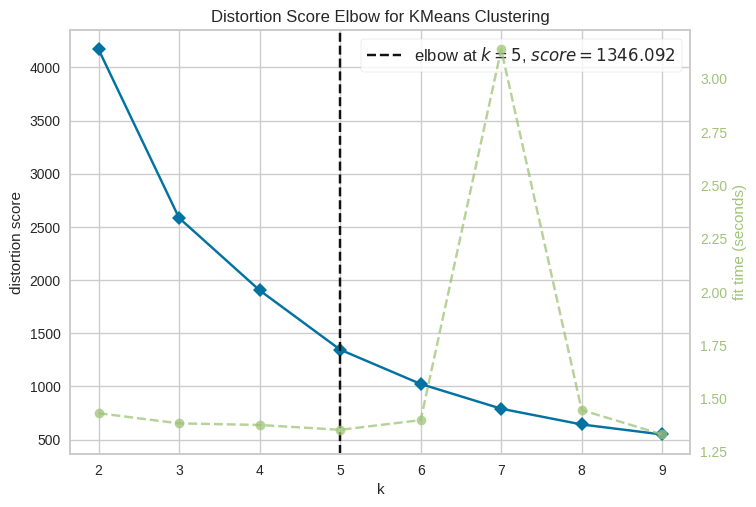

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# 2. Determinar o número ideal de clusters:
inertia = []
for i in range(1, 11):  # Testando de 1 a 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10, ).fit(df_items_scaled)  # Definido n_init explicitamente
    inertia.append(kmeans.inertia_)
    visualizer = KElbowVisualizer(kmeans, k=(2,10))

visualizer.fit(df_items_scaled)
visualizer.show()
plt.show()

## Coeficiente de silhueta

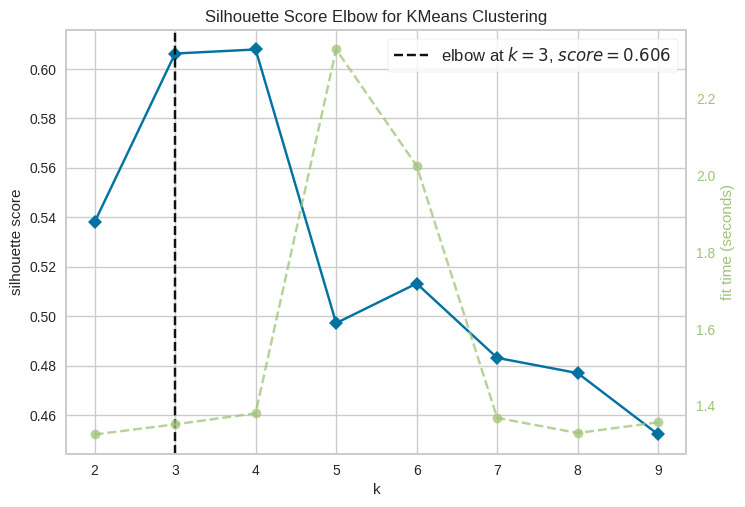

In [ ]:
inertia = []
for i in range(1, 11):  # Testando de 1 a 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10, ).fit(df_items_scaled)  # Definido n_init explicitamente
    inertia.append(kmeans.inertia_)
    visualizer = KElbowVisualizer(kmeans, k=(2,10), metric='silhouette')

visualizer.fit(df_items_scaled)
visualizer.show()
plt.show()

In [ ]:
import plotly.express as px
# Scatter plot antes da clusterização
fig_before = px.scatter(df_items, x='sold_units', y='sell_price', title='Antes da Clusterização')
display(fig_before)

In [ ]:
# Selecionando as colunas de interesse
features = ['sold_units', 'sell_price']
one_hot_columns = one_hot_encoded.columns.tolist()  # As colunas que foram codificadas
selected_features = features + one_hot_columns

df_for_clustering = df_final_encoded[selected_features]


In [ ]:
df_for_clustering.head()

,sold_units,sell_price,event_Easter,event_NewYear,event_Ramadan starts,event_Sem evento,event_SuperBowl,event_Thanksgiving,region_Boston,region_New York,region_Philadelphia,store_Back_Bay,store_Brooklyn,store_Greenwich_Village,store_Harlem,store_Midtown_Village,store_Queen_Village,store_Roxbury,store_South_End,store_Tribeca,store_Yorktown,category_x_ACCESORIES,category_x_HOME_&_GARDEN,category_x_SUPERMARKET
0,0,11.036664,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,0,5.275608,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0,3.944025,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0,5.981872,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0,3.831799,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_for_clustering_scaled = pd.DataFrame(scaler.fit_transform(df_for_clustering), columns=df_for_clustering.columns)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

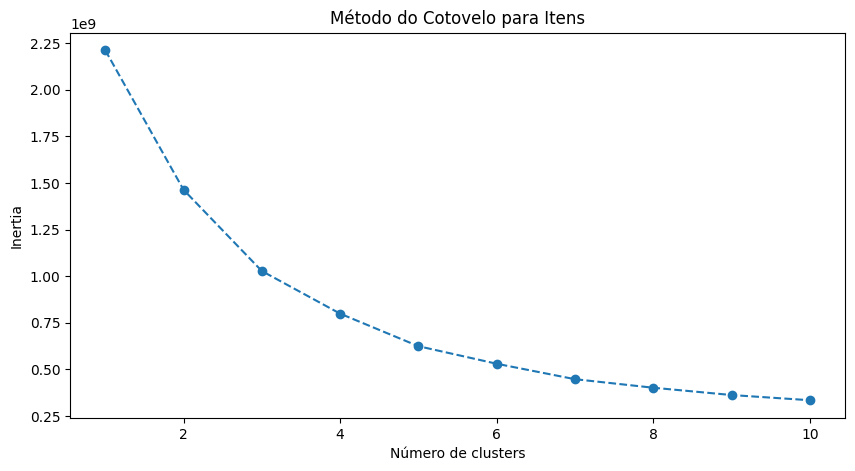

In [ ]:
# 2. Determinar o número ideal de clusters:

inertia = []
for i in range(1, 11):  # Testando de 1 a 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(df_for_clustering)  # Definido n_init explicitamente
    inertia.append(kmeans.inertia_)

# Plotando o Método do Cotovelo
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método do Cotovelo para Itens')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Aplicando o algoritmo K-means para 5 clusters
kmeans_5 = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(df_items_scaled)

# Adicionando as etiquetas de cluster ao DataFrame original
df_items['cluster_label'] = kmeans_5.labels_

# Agora, o DataFrame df_items tem uma nova coluna chamada 'cluster_label', que indica a qual dos 6 clusters cada item pertence.
print(df_items)

                   item  sold_units  sell_price  unique_stores  \
0      ACCESORIES_1_001        4093   11.036624             10   
1      ACCESORIES_1_002        5059    5.276473             10   
2      ACCESORIES_1_003        1435    3.943962             10   
3      ACCESORIES_1_004       39175    5.981396             10   
4      ACCESORIES_1_005       14621    3.833273             10   
...                 ...         ...         ...            ...   
3044  SUPERMARKET_3_823       15388    3.350180             10   
3045  SUPERMARKET_3_824        8325    3.030721             10   
3046  SUPERMARKET_3_825       13526    4.938175             10   
3047  SUPERMARKET_3_826       12188    1.539785             10   
3048  SUPERMARKET_3_827       11377    1.199388             10   

      unique_regions  cluster_label  
0                  3              1  
1                  3              3  
2                  3              3  
3                  3              3  
4                

In [ ]:
# Inicializar figura
fig = go.Figure()

# Adiciona scatter plot para cada cluster
for cluster in df_items['cluster_label'].unique():
    cluster_data = df_items[df_items['cluster_label'] == cluster]
    fig.add_trace(go.Scatter(x=cluster_data['sold_units'],
                             y=cluster_data['sell_price'],
                             mode='markers',
                             name=f"Cluster {cluster}",
                             marker=dict(size=10,
                                         line=dict(width=2))))

# Personalizar layout
fig.update_layout(
    title='Distribuição de Unidades Vendidas e Preço de Venda por Cluster de Produtos',
    xaxis=dict(title='Unidades Vendidas'),
    yaxis=dict(title='Preço de Venda'),
    legend_title="Clusters"
)

# Mostrar figura
fig.show()


# DBSCAN

KeyboardInterrupt: ignored

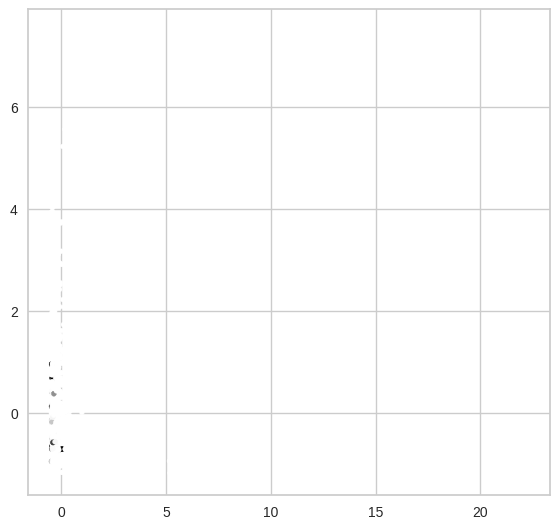

In [ ]:
import random
from scipy.spatial import distance
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np

# Parâmetros DBSCAN
min_samples = 10
eps = 0.02  # Defina o valor de epsilon adequado para o seu caso
n_samples = df_items_scaled.shape[0]

# Inicialização das estruturas de dados
cluster_num = -1
remaining = dict()
clustered = dict()
visited = []
queue = []

# Incluir todas as amostras no conjunto de pontos restantes para visitar
for i in range(n_samples):
    remaining[i] = df_items_scaled[i]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.rcParams['figure.figsize'] = [6, 6]

for i in range(500):  # Número de iterações (ajuste conforme necessário)

    if len(queue) == 0:
        rand_idx = list(remaining.keys())[random.randint(0, len(remaining) - 1)]
        current_sample = remaining[rand_idx]
        cluster_num += 1
    else:
        temp = queue.pop(0)
        rand_idx = temp[0]
        current_sample = temp[1]

    distance_vals = np.array([[i, distance.euclidean(current_sample, df_items_scaled[i])] for i in range(n_samples)])
    filtered_distances = distance_vals[np.where(distance_vals[:, 1] < eps), :][0]
    sorted_distances = filtered_distances[filtered_distances[:, 1].argsort()]

    if sorted_distances.shape[0] > min_samples:
        if len(queue) == 0:
            clustered[rand_idx] = cluster_num
        indexes = sorted_distances[:, 0].astype(int)
        for idx in indexes:
            clustered[idx] = cluster_num
            if not any(q[0] == idx for q in queue) and idx != rand_idx and idx not in visited:
                queue.append((idx, df_items_scaled[idx]))
                remaining.pop(idx, None)

    visited.append(rand_idx)

    labels = np.array([-1] * n_samples)
    indexes = list(clustered.keys())
    labels[indexes] = list(clustered.values())
    labels[rand_idx] = 2

    ax.cla()
    ax.scatter(df_items_scaled[:, 0], df_items_scaled[:, 1], c=labels, marker=".")

    clear_output(wait=True)
    display(fig)


In [ ]:
n_samples = df_items_scaled.shape[0]
n_samples

3049

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

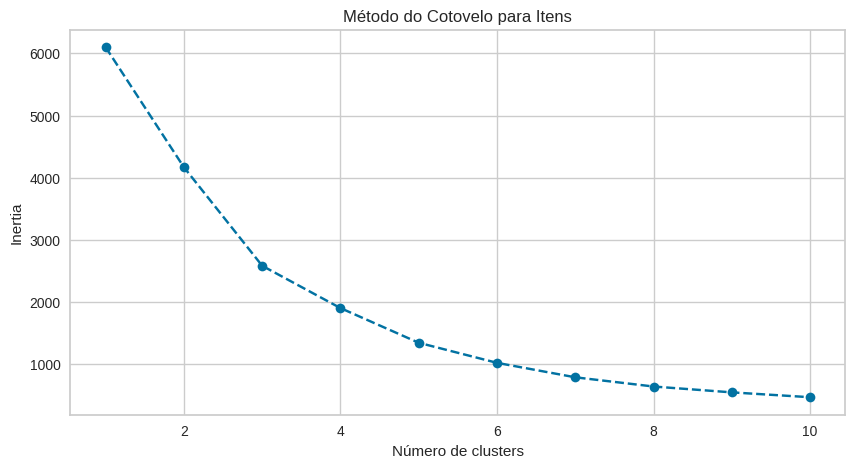

In [ ]:

# 2. Determinar o número ideal de clusters:

inertia = []
for i in range(1, 11):  # Testando de 1 a 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(df_items_scaled)  # Definido n_init explicitamente
    inertia.append(kmeans.inertia_)

# Plotando o Método do Cotovelo
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método do Cotovelo para Itens')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.show()



In [ ]:
# Ajuste do modelo KMeans com 6 clusters
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10).fit(df_items_scaled)

# Adicionando os rótulos dos clusters ao dataframe original
df_items['cluster_label'] = kmeans.labels_

# Examinando os clusters
for i in range(5):
    print(f"Cluster {i}:")
    display(df_items[df_items['cluster_label'] == i].head())


Cluster 0:


,item,sold_units,sell_price,unique_stores,unique_regions,cluster_label
1,ACCESORIES_1_002,5059,5.28,10,3,0
2,ACCESORIES_1_003,1435,3.94,10,3,0
3,ACCESORIES_1_004,39175,5.98,10,3,0
4,ACCESORIES_1_005,14621,3.83,10,3,0
5,ACCESORIES_1_006,13068,1.34,10,3,0


Cluster 1:


,item,sold_units,sell_price,unique_stores,unique_regions,cluster_label
0,ACCESORIES_1_001,4093,11.04,10,3,1
6,ACCESORIES_1_007,3014,10.48,10,3,1
11,ACCESORIES_1_012,7326,8.60,10,3,1
21,ACCESORIES_1_022,7357,9.50,10,3,1
23,ACCESORIES_1_024,3802,11.80,10,3,1


Cluster 2:


,item,sold_units,sell_price,unique_stores,unique_regions,cluster_label
7,ACCESORIES_1_008,87645,0.63,10,3,2
14,ACCESORIES_1_015,84541,0.94,10,3,2
173,ACCESORIES_1_178,90433,0.63,10,3,2
246,ACCESORIES_1_254,87155,0.94,10,3,2
260,ACCESORIES_1_268,95171,0.63,10,3,2


Cluster 3:


,item,sold_units,sell_price,unique_stores,unique_regions,cluster_label
17,ACCESORIES_1_018,1279,15.72,10,3,3
19,ACCESORIES_1_020,4483,16.19,10,3,3
20,ACCESORIES_1_021,6736,15.71,10,3,3
25,ACCESORIES_1_026,3424,23.85,10,3,3
26,ACCESORIES_1_027,2033,26.56,10,3,3


Cluster 4:


,item,sold_units,sell_price,unique_stores,unique_regions,cluster_label
2314,SUPERMARKET_3_090,1002529,1.63,10,3,4
2476,SUPERMARKET_3_252,565299,1.83,10,3,4
2779,SUPERMARKET_3_555,491287,1.92,10,3,4
2810,SUPERMARKET_3_586,920242,1.92,10,3,4


Cluster 0: Este cluster parece conter itens de acessórios que têm preços moderados e um número moderado de unidades vendidas. Todos esses produtos estão disponíveis em 10 lojas e 3 regiões únicas.

Cluster 1: Este cluster também é composto de itens de acessórios, mas com preços mais altos em comparação com o Cluster 0. As unidades vendidas também são variadas, mas tendem a ser menores do que no Cluster 0. Novamente, a disponibilidade é a mesma em 10 lojas e 3 regiões únicas.

Cluster 2: Este cluster destaca-se por ter um número muito alto de unidades vendidas e preços muito baixos. Todos são itens de acessórios disponíveis em 10 lojas e 3 regiões únicas.

Cluster 3: Este cluster tem itens de acessórios com preços muito altos e um número moderado a baixo de unidades vendidas. Esses itens também estão disponíveis em 10 lojas e 3 regiões únicas.

Cluster 4: Este é claramente o cluster de produtos de supermercado com vendas extremamente altas e preços baixos a moderados. Novamente, a disponibilidade é a mesma em 10 lojas e 3 regiões únicas.

In [ ]:
from sklearn.cluster import KMeans

# Aplicando o algoritmo K-means para 6 clusters
kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(df_items_scaled)

# Adicionando as etiquetas de cluster ao DataFrame original
df_items['cluster_label'] = kmeans_5.labels_

# Agora, o DataFrame df_items tem uma nova coluna chamada 'cluster_label', que indica a qual dos 6 clusters cada item pertence.
print(df_items)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



                   item  sold_units  sell_price  unique_stores  \
0      ACCESORIES_1_001        4093       11.04             10   
1      ACCESORIES_1_002        5059        5.28             10   
2      ACCESORIES_1_003        1435        3.94             10   
3      ACCESORIES_1_004       39175        5.98             10   
4      ACCESORIES_1_005       14621        3.83             10   
...                 ...         ...         ...            ...   
3044  SUPERMARKET_3_823       15388        3.35             10   
3045  SUPERMARKET_3_824        8325        3.03             10   
3046  SUPERMARKET_3_825       13526        4.94             10   
3047  SUPERMARKET_3_826       12188        1.54             10   
3048  SUPERMARKET_3_827       11377        1.20             10   

      unique_regions  cluster_label  
0                  3              1  
1                  3              0  
2                  3              0  
3                  3              0  
4                

In [ ]:
import plotly.graph_objects as go

# Suponha que df_items é o seu DataFrame

# Inicializar figura
fig = go.Figure()

# Adiciona scatter plot para cada cluster
for cluster in df_items['cluster_label'].unique():
    cluster_data = df_items[df_items['cluster_label'] == cluster]
    fig.add_trace(go.Scatter(x=cluster_data['sold_units'],
                             y=cluster_data['sell_price'],
                             mode='markers',
                             name=f"Cluster {cluster}",
                             marker=dict(size=10,
                                         line=dict(width=2))))

# Personalizar layout
fig.update_layout(
    title='Distribuição de Unidades Vendidas e Preço de Venda por Cluster de Produtos',
    xaxis=dict(title='Unidades Vendidas'),
    yaxis=dict(title='Preço de Venda'),
    legend_title="Clusters"
)

# Mostrar figura
fig.show()



In [ ]:
# Importando bibliotecas
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.metrics import silhouette_score

# Lendo e pré-processando os dados (substitua pelo seu próprio DataFrame)
# df_items = pd.read_csv('seu_arquivo.csv')
# Supondo que df_items já esteja definido

# Escalando as características
scaler = StandardScaler()
df_items_scaled = scaler.fit_transform(df_items[['sold_units', 'sell_price', 'unique_stores', 'unique_regions']])

# Treinando o modelo K-means com 5 clusters
kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(df_items_scaled)

# Verificando as formas para garantir a compatibilidade
if df_items_scaled.shape[0] == df_items.shape[0]:
    df_items['cluster_label'] = kmeans_5.labels_
else:
    raise ValueError("O DataFrame df_items_scaled deve ter as mesmas dimensões de df_items.")

# Gráfico de dispersão 3D
fig = px.scatter_3d(df_items,
                    x='sold_units',
                    y='sell_price',
                    z='unique_stores',
                    color='cluster_label',
                    labels={'sold_units': 'Sold Units', 'sell_price': 'Sell Price', 'unique_stores': 'Unique Stores Sold In'},
                    title="3D Scatter Plot of Item Clusters",
                    color_continuous_scale=px.colors.qualitative.Set1,
                    hover_data=['item'])
fig.show()

# Calculando o coeficiente de silhueta
silhouette_avg = silhouette_score(df_items_scaled, df_items['cluster_label'])
print(f"O coeficiente de silhueta médio para os clusters é: {silhouette_avg:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



O coeficiente de silhueta médio para os clusters é: 0.50
